## Music Style Detector : dataset creation

This notebook contains step to create a dataset for the music style detector. It uses the [FMA](https://github.com/mdeff/fma) large dataset and the [GTZAN](https://www.kaggle.com/datasets/andradaolteanu/gtzan-dataset-music-genre-classification) dataset (that will onlybe used for testing).

### 1. Import libraries

In [23]:
import os
import shutil
import pandas as pd
import matplotlib.pyplot as plt
import torchaudio
import multiprocessing

### 2. Load and prepare data

In [24]:
DATA_PATH = os.path.abspath(os.path.join(os.getcwd(), os.pardir, '../models/style_detector/data'))
fma_tracks = pd.read_csv(os.path.join(DATA_PATH, 'FMA/fma_metadata/tracks.csv'), index_col=0, header=[0, 1])
fma_genres = pd.read_csv(os.path.join(DATA_PATH, 'FMA/fma_metadata/genres.csv'))
gtzan_features = pd.read_csv(os.path.join(DATA_PATH, 'GTZAN/features_30_sec.csv'))

#### 2.1 FMA

The large dataset contains 106574 tracks, which is not store in the repository, neither tracked by dvc (because of the size of > 90GB).
We will then create and store a subset of it by selecting the genres that are the most represented and the one that are similar to the GTZAN dataset.

Text(0.5, 1.0, 'GTZAN genres')

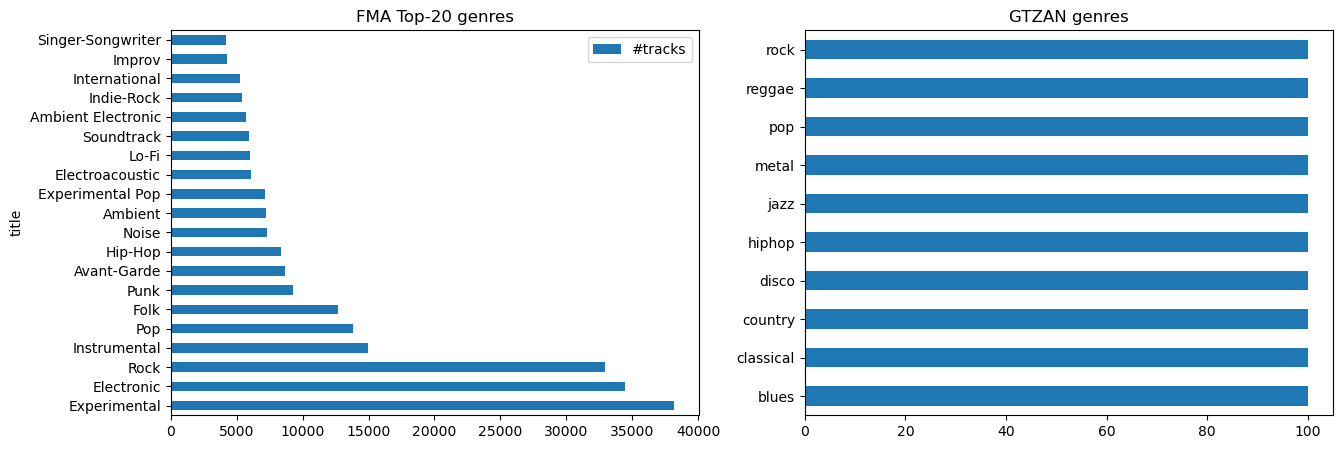

In [3]:
# sort genres by number of tracks
fma_genres = fma_genres.sort_values('#tracks', ascending=False)
# gtzan genres
gtzan_genres = gtzan_features[['filename', 'label']]
# subplot of two bar charts
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15, 5))
# plot top 20 genres for FMA
fma_genres.head(20).plot(kind='barh', x='title', y='#tracks', ax=ax1)
ax1.set_title('FMA Top-20 genres')
# plot number of tracks per genre for GTZAN
gtzan_genres['label'].value_counts().plot(kind='barh', ax=ax2)
ax2.set_title('GTZAN genres')

The common genres in the Top-20 genres of FMA data and the genres of GTZAN are:
- Hip-Hop
- Pop
- Rock

We will also keep the some famous genres that are not present in GTZAN:
- Electronic
- Lo-Fi

We must now find in the FMA dataset the other genres that are the same as the ones in GTZAN genres.

In [19]:
fma_kept_genres = ['Hip-Hop', 'Pop', 'Rock', 'Electronic', 'Lo-Fi']
missing_genres = ['Blues', 'Classical', 'Country', 'Disco', 'Jazz', 'Metal', 'Reggae']

# find all title genres in fma that contains the missing genres (ignore case)
found_title = {}
for genre in fma_genres['title']:
    for missing_genre in missing_genres:
        if missing_genre.lower() in genre.lower():
            # add title, number of tracks, genre_id and genre_top to found_title
            found_title[genre] = [fma_genres[fma_genres['title'] == genre]['#tracks'].values[0], fma_genres[fma_genres['title'] == genre]['genre_id'].values[0], fma_genres[fma_genres['title'] == genre]['top_level'].values[0]]

found_title

{'Jazz': [4126, 4, 4],
 'Classical': [4106, 5, 5],
 'Country': [1987, 9, 9],
 'Blues': [1752, 3, 3],
 'Free-Jazz': [1531, 74, 4],
 'Metal': [1498, 31, 12],
 'Contemporary Classical': [1239, 659, 5],
 'Reggae - Dub': [880, 79, 2],
 'Disco': [367, 11, 14],
 '20th Century Classical': [292, 187, 5],
 'Jazz: Out': [291, 97, 4],
 'Death-Metal': [196, 101, 12],
 'Black-Metal': [152, 167, 12],
 'Nu-Jazz': [120, 810, 13],
 'Modern Jazz': [107, 906, 4],
 'Jazz: Vocal': [97, 37, 4],
 'Reggae - Dancehall': [94, 602, 2],
 'Country & Western': [79, 651, 9]}

We see that some genres are present many times, under different names. We'll take only 1000 tracks per genre, in order to create a balanced dataset, that is not too big. Disco and Reggae will be a bit under-represented, but we will keep it anyway.
We also see that Metal, Reggae and Disco are not a top level genre, so we will update the genre_top of tracks when genres column are equal either to [79] or [94] (for reggae), [31], [101] or [167] (for metal) and [11] (for disco).

In [20]:
too_add = ['Jazz', 'Classical', 'Country', 'Blues', 'Metal', 'Reggae - Dub', 'Disco']
fma_kept_genres.extend(too_add)
fma_tracks = fma_tracks['track'][['genre_top', 'genres', 'genres_all']]
# update genre_top for tracks that contains genres 31 and 12 in the genres columns (with str.contains)
fma_tracks.loc[fma_tracks['genres'].str.contains('31') & fma_tracks['genres'].str.contains('12'), 'genre_top'] = 'Metal'
fma_tracks.loc[fma_tracks['genres'].isin(['[79]', '[94]']), 'genre_top'] = 'Reggae - Dub'
fma_tracks.loc[fma_tracks['genres'].isin(['[11]']), 'genre_top'] = 'Disco'
# delete tracks where genre_top is Rock and genres is not exactly equal to [12] (we want to keep only Rock tracks that are exclusively Rock)
fma_tracks = fma_tracks.drop(fma_tracks[(fma_tracks['genre_top'] == 'Rock') & (fma_tracks['genres'] != '[12]')].index)
# same for electronic ([15])
fma_tracks = fma_tracks.drop(fma_tracks[(fma_tracks['genre_top'] == 'Electronic') & (fma_tracks['genres'] != '[15]')].index)
# same for Hip-Hop ([21])
fma_tracks = fma_tracks.drop(fma_tracks[(fma_tracks['genre_top'] == 'Hip-Hop') & (fma_tracks['genres'] != '[21]')].index)

In [21]:
# only keep genres that are in fma_kept_genres
fma_tracks = fma_tracks[fma_tracks['genre_top'].isin(fma_kept_genres)]
fma_tracks['genre_id'] = fma_tracks['genre_top'].map(fma_genres.set_index('title')['genre_id'])
# rename 'Reggae - Dub' to 'Reggae'
fma_tracks['genre_top'] = fma_tracks['genre_top'].replace('Reggae - Dub', 'Reggae')
fma_tracks.head(-1)

,genre_top,genres,genres_all,genre_id
track_id,,,,
2,Hip-Hop,[21],[21],21
3,Hip-Hop,[21],[21],21
5,Hip-Hop,[21],[21],21
10,Pop,[10],[10],10
134,Hip-Hop,[21],[21],21
...,...,...,...,...
154613,Metal,"[31, 32, 1235]","[32, 38, 12, 1235, 31]",31
154614,Metal,"[31, 32, 1235]","[32, 38, 12, 1235, 31]",31
154680,Metal,"[12, 31, 360]","[38, 6, 360, 12, 31]",31


In [22]:
# print the number of tracks per genre
fma_tracks['genre_top'].value_counts()

Hip-Hop       2735
Electronic    2689
Pop           2332
Rock          1896
Classical     1230
Jazz           571
Reggae         400
Metal          211
Country        194
Blues          110
Disco           77
Name: genre_top, dtype: int64

In [23]:
# create list of genre that contains more than 1000 tracks
genres_above_1000 = []
for genre in fma_tracks['genre_top'].unique():
    if fma_tracks[fma_tracks['genre_top'] == genre].shape[0] > 1000:
        genres_above_1000.append(genre)

# create a new dataframe with only the genres that contains more than 1000 tracks
df_genres_above_1000 = fma_tracks[fma_tracks['genre_top'].isin(genres_above_1000)]

In [24]:
# keep randomly 1000 tracks per genre
df_genres_above_1000 = df_genres_above_1000.groupby('genre_top', group_keys=False).apply(lambda x: x.sample(min(len(x), 1000)))
df_genres_above_1000['genre_top'].value_counts()

Classical     1000
Electronic    1000
Hip-Hop       1000
Pop           1000
Rock          1000
Name: genre_top, dtype: int64

In [25]:
# create a new dataframe with only the genres that contains less than 1000 tracks
df_genres_below_1000 = fma_tracks[~fma_tracks['genre_top'].isin(genres_above_1000)]
# merge the two dataframes
fma_tracks = pd.concat([df_genres_above_1000, df_genres_below_1000])
# print values of genre_id
fma_tracks['genre_id'].value_counts()

5     1000
15    1000
21    1000
10    1000
12    1000
4      571
79     400
31     211
9      194
3      110
11      77
Name: genre_id, dtype: int64

In [26]:
# check that genre_top + genre_id are unique (shape must be equal to (11,2))
print(fma_tracks[['genre_top', 'genre_id']].drop_duplicates().shape)
# drop genres and genres_all columns
fma_tracks = fma_tracks.drop(['genres', 'genres_all'], axis=1)
# rename 'genre_top' to 'genre_label'
fma_tracks = fma_tracks.rename(columns={'genre_top': 'genre_label'})
fma_tracks.head(-1)

(11, 2)


,genre_top,genre_id
track_id,,
82066,Classical,5
65795,Classical,5
11721,Classical,5
145568,Classical,5
70936,Classical,5
...,...,...
154613,Metal,31
154614,Metal,31
154680,Metal,31


In [27]:
# create a dictionary mapping genre and genre_id
genre_to_id = dict(zip(fma_tracks['genre_top'], fma_tracks['genre_id']))
print(genre_to_id)

{'Classical': 5, 'Electronic': 15, 'Hip-Hop': 21, 'Pop': 10, 'Rock': 12, 'Jazz': 4, 'Reggae': 79, 'Disco': 11, 'Blues': 3, 'Country': 9, 'Metal': 31}


In [28]:
# save as csv
fma_tracks.to_csv(os.path.join(DATA_PATH, 'FMA', 'fma_reduced_genres.csv'))

#### 2.2 GTZAN

In [29]:
gtzan_genres = gtzan_features[['filename', 'label']]
# print the number of tracks per genre
gtzan_genres['label'].value_counts()

blues        100
classical    100
country      100
disco        100
hiphop       100
jazz         100
metal        100
pop          100
reggae       100
rock         100
Name: label, dtype: int64

In [30]:
# apply the same mapping as in FMA (to the closest genre)
gtzan_genres['label'] = gtzan_genres['label'].map({'blues': 'Blues', 'classical': 'Classical', 'country': 'Country', 'disco': 'Disco', 'hiphop': 'Hip-Hop', 'jazz': 'Jazz', 'metal': 'Metal', 'pop': 'Pop', 'reggae': 'Reggae', 'rock': 'Rock'})
# add a column with the genre_id
gtzan_genres['genre_id'] = gtzan_genres['label'].map(genre_to_id)
# rename 'label' column to 'genre_label'
gtzan_genres = gtzan_genres.rename(columns={'label': 'genre_label'})
gtzan_genres.head()

/tmp/ipykernel_16249/353602912.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  gtzan_genres['label'] = gtzan_genres['label'].map({'blues': 'Blues', 'classical': 'Classical', 'country': 'Country', 'disco': 'Disco', 'hiphop': 'Hip-Hop', 'jazz': 'Jazz', 'metal': 'Metal', 'pop': 'Pop', 'reggae': 'Reggae', 'rock': 'Rock'})
/tmp/ipykernel_16249/353602912.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  gtzan_genres['genre_id'] = gtzan_genres['label'].map(genre_to_id)


,filename,label,genre_id
0,blues.00000.wav,Blues,3
1,blues.00001.wav,Blues,3
2,blues.00002.wav,Blues,3
3,blues.00003.wav,Blues,3
4,blues.00004.wav,Blues,3


In [31]:
# save as csv
gtzan_genres.to_csv(os.path.join(DATA_PATH, 'GTZAN', 'gtzan_genres.csv'), index=False)

### 3. Create dataset

Now that we have the list of tracks of our FMA dataset, we will keep only the songs files that are in this list, in order to create a final dataset that we will be tracked by dvc.

In [5]:
folder_destination = os.path.join(DATA_PATH, 'FMA', 'fma_reduced')
# create the destination folder if it doesn't exist
if not os.path.exists(folder_destination):
    os.makedirs(folder_destination)
folder_source = os.path.join(DATA_PATH, 'FMA', 'fma_large')
# list the tracks that are in our FMA dataset (index of fma_tracks)
tracks = fma_tracks.index

In [33]:
# for each mp3 file in the source folder (and its subfolders), if the track_id is in our list of tracks, copy the file to the destination folder
for root, dirs, files in os.walk(folder_source):
    for file in files:
        if file.endswith(".mp3"):
            track_id = int(file.split('.')[0])
            if track_id in tracks:
                shutil.copy(os.path.join(root, file), os.path.join(folder_destination, file))
print("Done")

Done


For GTZAN, we will simply move the files to the destination folder and delete at the end the empty folders.

In [32]:
folder_source = os.path.join(DATA_PATH, 'GTZAN', 'genres_original')
folder_destination = os.path.join(DATA_PATH, 'GTZAN', 'genres_original_all')

# create the destination folder if it doesn't exist
if not os.path.exists(folder_destination):
    os.makedirs(folder_destination)

for subfolder in os.listdir(folder_source):
    # copy all the files from the subfolder to the destination folder
    for file in os.listdir(os.path.join(folder_source, subfolder)):
        shutil.copy(os.path.join(folder_source, subfolder, file), folder_destination)
print("Done")

Done


#### 3.1. Convert to filenames (post modification)

It is easier to have the filenames directly referenced in the dataset, so we will convert the track_id to filenames.

In [7]:
# load the csv file
fma_tracks = pd.read_csv(os.path.join(DATA_PATH, 'FMA', 'fma_reduced_genres_old.csv'))
fma_tracks.head()

,filename,genre_label,genre_id
0,082066.mp3,Classical,5
1,065795.mp3,Classical,5
2,011721.mp3,Classical,5
3,145568.mp3,Classical,5
4,070936.mp3,Classical,5


In [26]:
# add zeros at the beginning of the track_id to have a filename of length 6 with the extension .mp3
def add_zeros(track_id):
    track_id = str(track_id)
    while len(track_id) < 6:
        track_id = '0' + track_id
    return track_id + '.mp3'

In [27]:
# replace the track_id by the filename
fma_tracks['track_id'] = fma_tracks['track_id'].apply(add_zeros)
# rename the track_id column to filename
fma_tracks = fma_tracks.rename(columns={'track_id': 'filename'})
fma_tracks.head()

,filename,genre_label,genre_id
0,082066.mp3,Classical,5
1,065795.mp3,Classical,5
2,011721.mp3,Classical,5
3,145568.mp3,Classical,5
4,070936.mp3,Classical,5


#### 3.2. Renumbered genre_id (post modification)

It is easier to work with genre_id that are consecutive numbers, starting from 0 to n-1, so we will renumber the genre_id.

In [10]:
# map each genre to a consecutive integer
new_id = sorted(fma_tracks['genre_label'].unique())
new_id = dict(zip(new_id, range(len(new_id))))
# replace the genre_id by the new_id
fma_tracks['genre_id'] = fma_tracks['genre_label'].map(new_id)
fma_tracks.head()

,filename,genre_label,genre_id
0,082066.mp3,Classical,1
1,065795.mp3,Classical,1
2,011721.mp3,Classical,1
3,145568.mp3,Classical,1
4,070936.mp3,Classical,1


In [11]:
# save as csv
fma_tracks.to_csv(os.path.join(DATA_PATH, 'FMA', 'fma_reduced_genres.csv'), index=False)

In [12]:
# load the GTZAN csv file
gtzan_genres = pd.read_csv(os.path.join(DATA_PATH, 'GTZAN', 'gtzan_genres.csv'))

,filename,genre_label,genre_id
0,blues.00000.wav,Blues,0
1,blues.00001.wav,Blues,0
2,blues.00002.wav,Blues,0
3,blues.00003.wav,Blues,0
4,blues.00004.wav,Blues,0


In [ ]:
gtzan_genres['genre_id'] = gtzan_genres['genre_label'].map(new_id)
gtzan_genres.head()

In [13]:
# save as csv
gtzan_genres.to_csv(os.path.join(DATA_PATH, 'GTZAN', 'gtzan_genres.csv'), index=False)

#### 3.3. Check for damaged files

Some files may not be readable during the training of the model, we will check for them and remove them from the dataset.
We will walk through files in parallel, using the multiprocessing library.

In [19]:
import concurrent.futures

fma_source_folder = os.path.join(DATA_PATH, 'FMA', 'fma_reduced')
gtzan_source_folder = os.path.join(DATA_PATH, 'GTZAN', 'genres_original_all')
fma_df = pd.read_csv(os.path.join(DATA_PATH, 'FMA', 'fma_reduced_genres.csv'))
gtzan_df = pd.read_csv(os.path.join(DATA_PATH, 'GTZAN', 'gtzan_genres.csv'))

In [20]:
def process_file(entry, df):
    # do something with the file or directory
    try:
        torchaudio.load(entry.path)
    except:
        print(entry.path + " is corrupted... deleting it")
        os.remove(entry.path) # remove the corrupted file
        # remove the row from the dataframe
        df.drop(df[df['filename'] == entry.name].index, inplace=True)

def process_directory(directory, df):
    with concurrent.futures.ThreadPoolExecutor() as executor:
        for entry in os.scandir(directory):
            if entry.is_file():
                executor.submit(process_file, entry, df)


In [21]:
print("Dataframe size before processing: " + str(len(fma_df)))
process_directory(fma_source_folder, fma_df)
print("Dataframe size after processing: " + str(len(fma_df)))
fma_df.to_csv(os.path.join(DATA_PATH, 'FMA', 'fma_reduced_genres_new.csv'), index=False)

c:\Users\benja\Projects\MLodImage\code\models\data\sound_classification\FMA\fma_reduced\001486.mp3 is corrupted... deleting it
c:\Users\benja\Projects\MLodImage\code\models\data\sound_classification\FMA\fma_reduced\065753.mp3 is corrupted... deleting it


In [22]:
print("Dataframe size before processing: " + str(len(gtzan_df)))
process_directory(gtzan_source_folder, gtzan_df)
print("Dataframe size after processing: " + str(len(gtzan_df)))
gtzan_df.to_csv(os.path.join(DATA_PATH, 'GTZAN', 'gtzan_genres_new.csv'), index=False)

Dataframe size before processing: 1000
c:\Users\benja\Projects\MLodImage\code\models\data\sound_classification\GTZAN\genres_original_all\jazz.00054.wav is corrupted... deleting it
Dataframe size after processing: 999
